# 순환 신경망으로 IMDB 리뷰 분류하기

In [1]:
import tensorflow as tf

tf.keras.utils.set_random_seed(42)

In [2]:
#케라스로 IMDB 데이터 불러오기
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=200)

print(train_input.shape, test_input.shape)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(25000,) (25000,)


> 훈련 세트 준비

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

lengths = np.array([len(x) for x in train_input])
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


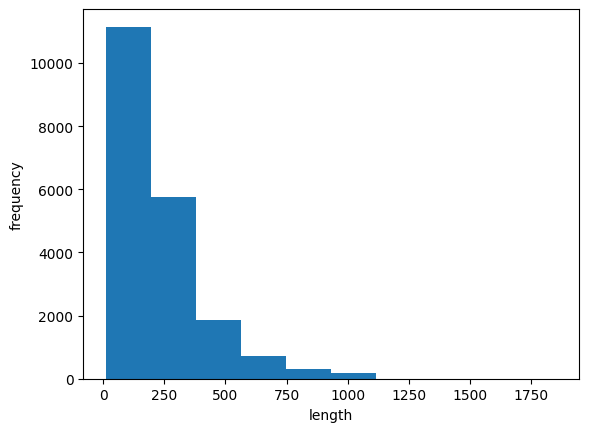

In [4]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

> 시퀀스 패딩

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)

print(train_seq.shape)

val_seq = pad_sequences(val_input, maxlen=100)

(20000, 100)


> 순환 신경망 모델 만들기

In [7]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.SimpleRNN(8, input_shape=(100, 200)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


> 원-핫 인코딩

In [11]:
train_oh = keras.utils.to_categorical(train_seq)

val_oh = keras.utils.to_categorical(val_seq)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 8)                   │           1,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,681 (6.57 KB)

 Trainable params: 1,681 (6.57 KB)

 Non-trainable params: 0 (0.00 B)

> 모델 훈련

In [12]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64, validation_data=(val_oh, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.4945 - loss: 0.7135 - val_accuracy: 0.4924 - val_loss: 0.7053
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.5020 - loss: 0.7038 - val_accuracy: 0.4960 - val_loss: 0.7010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.5059 - loss: 0.6993 - val_accuracy: 0.4962 - val_loss: 0.6984
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5124 - loss: 0.6964 - val_accuracy: 0.5038 - val_loss: 0.6962
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.5154 - loss: 0.6943 - val_accuracy: 0.5110 - val_loss: 0.6939
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5195 - loss: 0.6925 - val_accuracy: 0.5120 - val_loss: 0.6925
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5228 - loss: 0.6915 - val_accuracy: 0.5162 - val_loss: 0.6917
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.5255 - loss: 0.6905

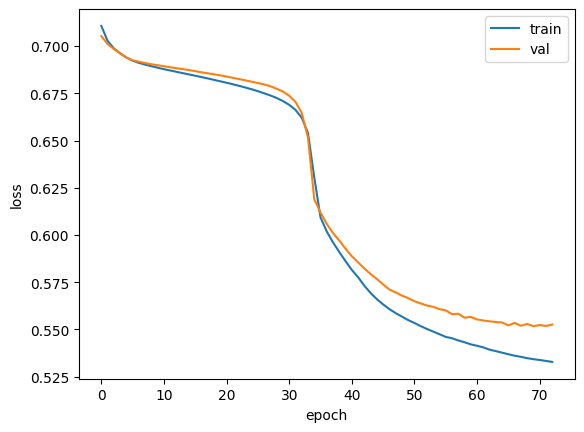

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

> 임베딩

In [14]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(200, 16, input_shape=(100,)))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 16)             │           3,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 8)                   │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,409 (13.32 KB)

 Trainable params: 3,409 (13.32 KB)

 Non-trainable params: 0 (0.00 B)

# LSTM과 GRU 셀

In [16]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

> LSTM 신경망

In [17]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

> 드롭아웃 적용하기

In [18]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

> 2개의 층을 연결하기

In [19]:
model3 = keras.Sequential()

model3.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 8)              │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,353 (36.54 KB)

 Trainable params: 9,353 (36.54 KB)

 Non-trainable params: 0 (0.00 B)

> GRU 신경망

In [20]:
model4 = keras.Sequential()

model4.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 8)                   │             624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,633 (33.72 KB)

 Trainable params: 8,633 (33.72 KB)

 Non-trainable params: 0 (0.00 B)